# Alzheimer's Severity Prediction from Brain X-ray Images
A Capstone project

In [5]:
%%capture
!pip install kaggle
!pip install sagemaker -U
!pip install smdebug

In [6]:
import pandas as pd
import numpy as np

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

import os
import json
from PIL import Image
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
from sklearn.metrics import confusion_matrix, accuracy_score

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-04-09 23:28:22.484 pytorch-1-12-gpu-py-ml-g4dn-xlarge-60d67c819515f85736f0b2ea671f:51 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?


## 1. Prepare dataset

### 1.1. Download the dataset

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
kaggle_username = "uyangas"
kaggle_key = "key"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images 

 59%|██████████████████████▎               | 20.0M/34.1M [00:00<00:00, 64.6MB/s]
100%|██████████████████████████████████████| 34.1M/34.1M [00:00<00:00, 74.7MB/s]


In [7]:
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o alzheimers-dataset-4-class-of-images.zip

In [10]:
data_root='/root/Alzheimer_s Dataset'

for data_type in os.listdir(data_root):
    
    print(f"<<< {data_type} >>>")
    data_dir = os.path.join(data_root, data_type)
    
    for sub_type in os.listdir(data_dir):
        sub_dir = os.path.join(data_dir, sub_type)
        print(f"{sub_type} images: {len(os.listdir(sub_dir))}")

<<< test >>>
MildDemented images: 179
VeryMildDemented images: 448
NonDemented images: 640
ModerateDemented images: 12
<<< train >>>
MildDemented images: 717
VeryMildDemented images: 1792
NonDemented images: 2560
ModerateDemented images: 52


### 1.2. Split the dataset

The dataset only contains `train` and `test` sets. Create `validation` set by randomly sampling `20%` of the `train` data

In [15]:
!mkdir /root/"Alzheimer_s Dataset"/valid

In [30]:
from_dir = os.path.join(data_root, 'train')
to_dir = os.path.join(data_root, 'valid')

for sub_type in os.listdir(from_dir):
    from_sub_dir = os.path.join(from_dir, sub_type)
    to_sub_dir = os.path.join(to_dir, sub_type)

    os.mkdir(to_sub_dir)
    print("Created: ", to_sub_dir)
    
    valid_samples = np.random.choice(os.listdir(from_sub_dir), int(0.2*len(os.listdir(from_sub_dir))))
    
    for file in valid_samples:
        rm_dir = os.path.join(from_sub_dir, file)
        cp_dir = os.path.join(to_sub_dir, file)
        
        try:
            os.rename(rm_dir, cp_dir)
        except:
            pass
        
    print(f"<<< {sub_type} moved to valid : {len(os.listdir(to_sub_dir))} >>>")

Created:  /root/Alzheimer_s Dataset/valid/MildDemented
<<< MildDemented moved to valid : 130 >>>
Created:  /root/Alzheimer_s Dataset/valid/VeryMildDemented
<<< VeryMildDemented moved to valid : 323 >>>
Created:  /root/Alzheimer_s Dataset/valid/NonDemented
<<< NonDemented moved to valid : 466 >>>
Created:  /root/Alzheimer_s Dataset/valid/ModerateDemented
<<< ModerateDemented moved to valid : 10 >>>


MildDemented : mildDem669.jpg


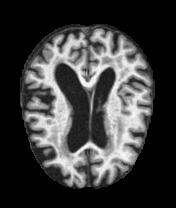

In [48]:
sub = random.choice(os.listdir(from_dir))
sub_dir = os.path.join(from_dir, sub)
image = random.choice(os.listdir(sub_dir))
img_dir = os.path.join(sub_dir, image)
img = Image.open(img_dir)

print(f"{sub} : {image}")
img

In [53]:
print(f"The size of the image: {np.array(img).shape}")

The size of the image: (208, 176)


### 1.3. Upload the dataset to S3

In [8]:
BUCKET = "capstone-us-data"

In [9]:
!aws s3 sync "Alzheimer_s Dataset" s3://{BUCKET}/"Alzheimer_s Dataset"

## 2. Pretrained model tuning and training

For pre-trained model, `VGG16` was chosen. 

### 2.1. Model tuning

In [16]:
role = sagemaker.get_execution_role()

data_channels = {
    "train": f"s3://{BUCKET}/Alzheimer_s Dataset/train/",
    "test": f"s3://{BUCKET}/Alzheimer_s Dataset/test/",
    "valid": f"s3://{BUCKET}/Alzheimer_s Dataset/valid/"
}

In [7]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": objective_metric_name, "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
estimator = PyTorch(
    entry_point="pre_hpo.py",
    base_job_name='pytorch_dementia_hpo',
    role=role,
    framework_version="1.9.0",
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    py_version='py38'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1, 
    objective_type=objective_type
)

In [ ]:
tuner.fit(
    data_channels,
    wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................!


In [9]:
exp = sagemaker.HyperparameterTuningJobAnalytics( hyperparameter_tuning_job_name='pytorch-training-230406-1921')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch-size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""",0.00800,pytorch-training-230406-1921-001-c114a446,Completed,1.034360,2023-04-06 19:22:39+00:00,2023-04-06 19:30:24+00:00,465.0
0,"""32""",0.03025,pytorch-training-230406-1921-002-a5368f12,Completed,1.033763,2023-04-06 19:31:54+00:00,2023-04-06 19:35:27+00:00,213.0


In [10]:
best_estimator = tuner.best_estimator()


2023-04-06 20:09:09 Starting - Found matching resource for reuse
2023-04-06 20:09:09 Downloading - Downloading input data
2023-04-06 20:09:09 Training - Training image download completed. Training in progress.
2023-04-06 20:09:09 Uploading - Uploading generated training model
2023-04-06 20:09:09 Completed - Resource retained for reuse


In [11]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.002385083227823211',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dementia_hpo-2023-04-06-19-55-31-692"',
 'sagemaker_program': '"pre_hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-403723872191/pytorch_dementia_hpo-2023-04-06-19-55-31-692/source/sourcedir.tar.gz"'}

### 2.2. Tuned Pre-trained model training

In [21]:
hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
    "lr": best_estimator.hyperparameters()['lr']}
hyperparameters

{'batch-size': 32, 'lr': '0.002385083227823211'}

In [10]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [11]:
output_path = f"s3://{BUCKET}/outputs/"

In [12]:
hook_config = DebuggerHookConfig(
    s3_output_path=output_path,
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output",
            parameters={"include_regex":"CrossEntropyLoss_output",
                        "train.save_interval": "1", 
                        "eval.save_interval": "1",
                        "predict.save_interval": "1"
            }
        )
    ],
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

metric_definitions=[
    {'Name': 'train:error', 'Regex': 'Train_error=(.*?);'},
    {'Name': 'validation:error', 'Regex': 'Valid_error=(.*?);'},
    {'Name': 'train:accuracy', 'Regex': 'Train_acc=(.*?);'},
    {'Name': 'validation:accuracy', 'Regex': 'Valid_acc=(.*?);'}
    ]

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
estimator = PyTorch(
    entry_point="pre_train_model.py",
    base_job_name="smdebugger-dementia-pytorch",
    role=role,
    hyperparameters=hyperparameters,
    instance_count=2,
    instance_type="ml.m5.2xlarge",
    framework_version="1.11.0",
    py_version="py38",
    output_path=output_path,
    metric_definitions=metric_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '10800'}
)

In [14]:
estimator.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-dementi

2023-04-07 16:34:48 Starting - Starting the training job...
2023-04-07 16:35:15 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-07 16:36:16 Downloading - Downloading input data...
2023-04-07 16:36:51 Training - Downloading the training image......
2023-04-07 16:37:51 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-07 12:37:47,739 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-07 12:37:47,741 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-07 12:37:47,743 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-04-07 12:37:47,754 sagemaker_pytorch_container.training IN

In [15]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-07 17:15:03.293 pytorch-1-12-gpu-py-ml-g4dn-xlarge-60d67c819515f85736f0b2ea671f:73 INFO s3_trial.py:42] Loading trial debug-output at path s3://capstone-us-data/outputs/smdebugger-dementia-pytorch-2023-04-07-16-34-41-148/debug-output
[2023-04-07 17:15:03.966 pytorch-1-12-gpu-py-ml-g4dn-xlarge-60d67c819515f85736f0b2ea671f:73 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 232 more expected)', IncompleteRead(0 bytes read, 232 more expected)) while reading s3://capstone-us-data/outputs/smdebugger-dementia-pytorch-2023-04-07-16-34-41-148/debug-output/index/000000000/000000000171_worker_0.json . Will retry now


In [16]:
trial

[2023-04-07 17:15:11.068 pytorch-1-12-gpu-py-ml-g4dn-xlarge-60d67c819515f85736f0b2ea671f:73 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-07 17:15:12.090 pytorch-1-12-gpu-py-ml-g4dn-xlarge-60d67c819515f85736f0b2ea671f:73 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7f279eb94f10>:(
    name=debug-output,
    path=s3://capstone-us-data/outputs/smdebugger-dementia-pytorch-2023-04-07-16-34-41-148/debug-output/,
    steps=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341,

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


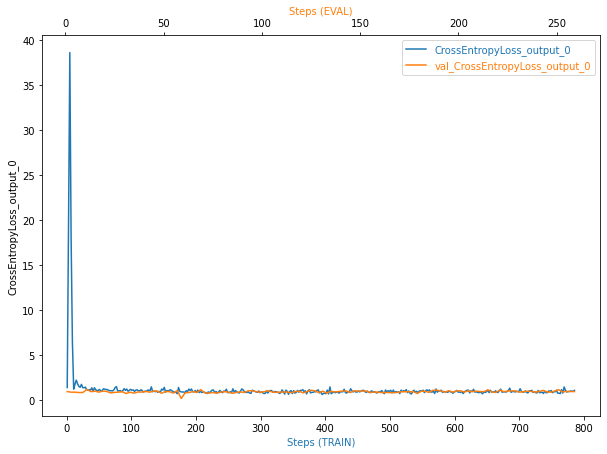

In [17]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "CrossEntropyLoss_output_0")

### 2.3. Pre-trained model deployment and testing

In [41]:
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.2xlarge")

INFO:sagemaker:Creating model with name: smdebugger-dementia-pytorch-2023-04-08-01-56-56-044
INFO:sagemaker:Creating endpoint-config with name smdebugger-dementia-pytorch-2023-04-08-01-56-56-044
INFO:sagemaker:Creating endpoint with name smdebugger-dementia-pytorch-2023-04-08-01-56-56-044


------!

In [63]:
ROOT = "/root/Alzheimer_s Dataset/test/"

transform = transforms.Compose([
        transforms.Resize(200), 
        transforms.ToTensor(),
        transforms.Normalize((0.497,0.402,0.425), (0.308, 0.325, 0.301))
    ])

data_image = ImageFolder(root=ROOT, transform=transform)
data_loader = torch.utils.data.DataLoader(data_image, batch_size=1, shuffle=True)

In [91]:
# get the labels
labels = []
predictions = []
for data, label in data_loader:
    labels.append(int(label))
    response = predictor.predict(data)
    predictions.append(np.argmax(response[0]))

In [103]:
print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(labels, predictions), 
                   columns=['Pred_Mild', 'Pred_Mod', 'Pred_Non', 'Pred_VeryMild'], 
                   index=['Mild', 'Moderate', 'Non', 'VeryMild']))
print("")
print("Test accuracy score: {:.3f}%".format(100*accuracy_score(labels, predictions)))

Confusion Matrix
          Pred_Mild  Pred_Mod  Pred_Non  Pred_VeryMild
Mild              0         0        19            160
Moderate          0         0         2             10
Non               0         0       427            213
VeryMild          0         0       139            309

Test accuracy score: 57.545%


In [104]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: smdebugger-dementia-pytorch-2023-04-08-01-56-56-044
INFO:sagemaker:Deleting endpoint with name: smdebugger-dementia-pytorch-2023-04-08-01-56-56-044


## 3. CNN model

In [11]:
hyperparameters = {'batch-size': 32, 'lr': '0.002385083227823211'}
hyperparameters

{'batch-size': 32, 'lr': '0.002385083227823211'}

In [12]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [13]:
output_path = f"s3://{BUCKET}/outputs/"

In [14]:
hook_config = DebuggerHookConfig(
    s3_output_path=output_path,
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output",
            parameters={"include_regex":"CrossEntropyLoss_output",
                        "train.save_interval": "1", 
                        "eval.save_interval": "1",
                        "predict.save_interval": "1"
            }
        )
    ],
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

metric_definitions=[
    {'Name': 'train:error', 'Regex': 'Train_error=(.*?);'},
    {'Name': 'validation:error', 'Regex': 'Valid_error=(.*?);'},
    {'Name': 'train:accuracy', 'Regex': 'Train_acc=(.*?);'},
    {'Name': 'validation:accuracy', 'Regex': 'Valid_acc=(.*?);'}
    ]

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dementia-pytorch-cnn",
    role=role,
    hyperparameters=hyperparameters,
    instance_count=2,
    instance_type="ml.m5.2xlarge",
    framework_version="1.11.0",
    py_version="py38",
    output_path=output_path,
    metric_definitions=metric_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '10800'}
)

In [ ]:
estimator.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-dementi

2023-04-09 23:33:33 Starting - Starting the training job..

### References

- https://pytorch.org/hub/pytorch_vision_vgg/
- https://discuss.pytorch.org/t/vgg-object-has-no-attribute-fc/9124
- https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html
- https://www.kaggle.com/code/fazainsyahazka/1301184335-alzheimer-s-disease-classification-cnn

The end of the notebook